In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("../data/train_ZoGVYWq.csv")
test = pd.read_csv("../data/test_66516Ee.csv")
submission = pd.read_csv("../data/sample_submission_sLex1ul.csv")

# Setup Data

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [4]:
#SETUP DATA
data = pd.concat([train, test], axis=0).reset_index(drop = True)
data["sourcing_channel"] = LabelEncoder().fit_transform(data["sourcing_channel"])
data["residence_area_type"] = LabelEncoder().fit_transform(data["residence_area_type"])

In [5]:
train = data[:train.shape[0]].reset_index(drop =True)
test = data[train.shape[0]:].reset_index(drop =True)

train_id = train[["id"]]
test_id = test[["id"]]
target = train.renewal

train = train.drop(["id","renewal"], axis=1)
test = test.drop(["id","renewal"], axis=1)

# Running  Model

In [6]:
import lightgbm as lgb
def model_lgb(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id):
    dtrain = lgb.Dataset(x_train, label=y_train,categorical_feature = ["sourcing_channel","residence_area_type"])
    dval = lgb.Dataset(x_test, label=y_test, categorical_feature = ["sourcing_channel","residence_area_type"])
    params = {
        "nthread":8,
        "bagging_fraction": 0.85,
        "feature_fraction": 0.85,
        "bagging_freq": 200,
        "metric":"auc",
        "objective": "binary",
        "learning_rate":0.15,
        "num_leaves":5,
        "max_depth":5,
        "silent":-1,
        "verbose":-1,
        "bagging_seed" : 987727,
        "seed":878738
    }
    model = lgb.train(params, dtrain, num_boost_round=5000,valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=100)
    meta_train[test_index] = model.predict(x_test, num_iteration=model.best_iteration or 5000)
    meta_test.append(model.predict(test, num_iteration=model.best_iteration or 5000))
    
    global meta_train_tid
    meta_train_tid[train_index] = model.predict(x_train, num_iteration=model.best_iteration or 5000)

    # Calculate Feature Importance
    global feature_importance
    gain = model.feature_importance('gain')
    feature_importance = feature_importance.append(pd.DataFrame({'feature':model.feature_name(), 'split':model.feature_importance('split'), 'gain':100 * gain / gain.sum()}), ignore_index=True)

In [7]:
meta_train = np.zeros(train.shape[0])
meta_train_tid = np.zeros(train.shape[0])
meta_test = []
feature_importance = pd.DataFrame(columns = ["feature","split","gain"])

kf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=33543)
for fold_id, (train_index, test_index) in enumerate(kf.split(train, target)):
    x_train, x_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]

    model_lgb(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id)

print "Overall Score:", roc_auc_score(target, meta_train)

test_id["renewal"] = pd.DataFrame(np.array(meta_test).T).rank(pct = True, axis=0).mean(axis=1)
train_id["renewal"] = meta_train
train_id["renewal_tid"] = meta_train_tid

/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.854415	valid_1's auc: 0.837807
[200]	training's auc: 0.862564	valid_1's auc: 0.836804
Early stopping, best iteration is:
[71]	training's auc: 0.851394	valid_1's auc: 0.838052
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.854114	valid_1's auc: 0.83915
[200]	training's auc: 0.861951	valid_1's auc: 0.836548
Early stopping, best iteration is:
[62]	training's auc: 0.849536	valid_1's auc: 0.840625
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.852079	valid_1's auc: 0.852935
[200]	training's auc: 0.859694	valid_1's auc: 0.851586
Early stopping, best iteration is:
[77]	training's auc: 0.848742	valid_1's auc: 0.853345
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.851549	valid_1's auc: 0.845231
[200]	training's auc: 0.858992	valid_1's auc: 0.844914
[300]	training's auc: 0.865531	valid_1's a

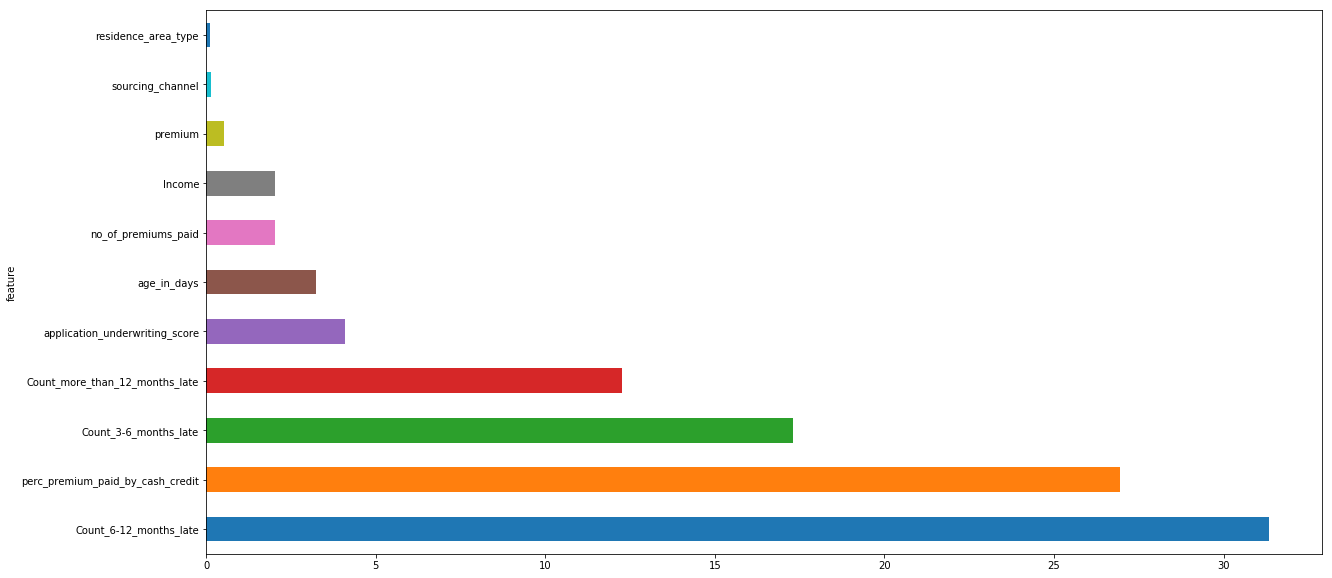

In [8]:
# Print Feature Importance
feature_importance = feature_importance.groupby("feature")["gain"].mean().reset_index().sort_values('gain', ascending=False).reset_index(drop=True)
plt.figure()
feature_importance[['feature','gain']].head(60).plot(kind='barh', x='feature', y='gain', legend=False, figsize=(20, 10));


# Working on Incentives

In [9]:
def get_effort(incentive):
    return 10*(1-np.exp(-incentive/400.0))
    
def get_improvement_in_renewal_probability(incentive):
    effort = get_effort(incentive)
    return 20*(1-np.exp(-effort/5.0))

def gradient_improvement_in_renewal_probability(incentive):
    dpde = 4 * np.exp(-get_effort(incentive)/5.0)
    dedi = np.exp(-incentive/400.0)/40.0
    dpdi = dpde * dedi
    return  dpdi
    
def revenue_score(incentive, benchmark, premium):
    cdp = get_improvement_in_renewal_probability(incentive)
    profits = ((benchmark + (cdp*benchmark/100.0)) * premium)-incentive
    return np.sum(profits)

def score_gradient(incentive, benchmark, premium):
    z=  np.exp(-incentive/400.0)-(incentive/400.0)-2
    return ((benchmark * premium * np.exp(z)/400.0)-1)

def second_score_gradient(incentive, benchmark, premium):
    a = np.exp(-incentive/400.0)-(incentive/400.0)
    b = (benchmark* premium* np.exp(a))/400.0
    return (-(b)-(1.0/400.0))/400.0

def learn(benchmark, premium, early_stopping = 5, start_incentive = 1700, min_improvement = 0.005, verbose = True):
    incentive = start_incentive
    best_incentive = start_incentive
    
    score = 0
    best_score = 0
    
    counter = 0
    best_counter = 0
    no_improvement_counter = 0
    
    while True:
        lr = (incentive - 0)
        gradient = score_gradient(incentive, benchmark, premium)
        try:
            incentive += lr*(gradient*0.5 + 0.5*prev_gradient)
        except:
            incentive += lr*gradient
            
        
        score = revenue_score(incentive, benchmark, premium)
        counter +=1
        prev_gradient = gradient

        if (score-best_score> min_improvement):
            best_score = score
            best_incentive = incentive
            best_counter = counter
            
            no_improvement_counter = 0
            if verbose: print "Epoch: {}, Incentive: {}, Score: {}, Gradient: {}".format(counter,incentive, score, gradient)
        else:
            if (no_improvement_counter > early_stopping):
                if verbose: print "Early Stopping, Best Iteration Round: {}".format(best_counter)
                return best_incentive, best_score
            else:
                no_improvement_counter +=1
                if verbose: print "Epoch: {}, Incentive: {}, Score: {}, Gradient: {}".format(counter,incentive, score, gradient)
    

In [10]:
def annealing(benchmark, premium, num_annealing = 30):
    results = []
    for incentive in range(0,premium,int(float(premium)/num_annealing)):
        results.append(learn(benchmark, premium, early_stopping = 5, start_incentive = incentive, min_improvement = 0.005, verbose = False))
    return sorted(results, key = lambda x: x[1])[-1][0]    

In [11]:
train_incentives = []

for i, (benchmark, premium) in enumerate(zip(train_id["renewal_tid"], train["premium"])):
    if i%10000 == 0: print "Completed {} Rows".format(i)
    train_incentives.append(annealing(benchmark, premium))
    
train_incentives = pd.Series(train_incentives)
train_incentives[train_incentives<0] = 0

generated_score = revenue_score(train_incentives, train_id["renewal_tid"], train["premium"])
baseline_score = revenue_score(pd.Series([1650]*len(train_incentives)), train_id["renewal_tid"], train["premium"])

print "Score using generated Incentive:",generated_score
print "Score using 1650 as Incentive:",baseline_score
print "Score Improvement:", generated_score/baseline_score

Completed 0 Rows
Completed 10000 Rows
Completed 20000 Rows
Completed 30000 Rows
Completed 40000 Rows
Completed 50000 Rows
Completed 60000 Rows
Completed 70000 Rows
Score using generated Incentive: 916891002.855
Score using 1650 as Incentive: 834398280.841
Score Improvement: 1.09886492327


In [12]:
test_incentives = []

for i, (benchmark, premium) in enumerate(zip(test_id["renewal"], test["premium"])):
    if i%10000 == 0: print "Completed {} Rows".format(i)
    test_incentives.append(annealing(benchmark, premium))
    
test_incentives = pd.Series(test_incentives)
test_incentives[test_incentives<0] = 0

generated_score = revenue_score(test_incentives, test_id["renewal"], test["premium"])
baseline_score = revenue_score(pd.Series([1650]*len(test_incentives)), test_id["renewal"], test["premium"])

print "Score using generated Incentive:",generated_score
print "Score using 1650 as Incentive:",baseline_score
print "Score Improvement:", generated_score/baseline_score

Completed 0 Rows
Completed 10000 Rows
Completed 20000 Rows
Completed 30000 Rows
Score using generated Incentive: 214800949.925
Score using 1650 as Incentive: 173006716.803
Score Improvement: 1.24157578327


# Training for Incentives

In [13]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

def model_lgb_regression(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id):
    dtrain = lgb.Dataset(x_train, label=y_train)
    dval = lgb.Dataset(x_test, label=y_test)
    params = {
        "nthread":8,
        "bagging_fraction": 0.85,
        "feature_fraction": 0.85,
        "bagging_freq": 200,
        "metric":"rmse",
        "objective": "regression",
        "learning_rate":0.05,
        "num_leaves":10,
        "max_depth":10,
        "silent":-1,
        "verbose":-1,
        "bagging_seed" : 242325,
        "seed":4244323
    }
    model = lgb.train(params, dtrain, num_boost_round=5000,valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=100)
    meta_train[test_index] = model.predict(x_test, num_iteration=model.best_iteration or 5000)
    meta_test.append(model.predict(test, num_iteration=model.best_iteration or 5000))

    # Calculate Feature Importance
    global feature_importance
    gain = model.feature_importance('gain')
    feature_importance = feature_importance.append(pd.DataFrame({'feature':model.feature_name(), 'split':model.feature_importance('split'), 'gain':100 * gain / gain.sum()}), ignore_index=True)

In [14]:
train["prediction"] = train_id["renewal"]
test["prediction"] = train_id["renewal"]

meta_train = np.zeros(train.shape[0])
meta_test = []
feature_importance = pd.DataFrame(columns = ["feature","split","gain"])

kf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=243453)
for fold_id, (train_index, test_index) in enumerate(kf.split(train, target)):
    x_train, x_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = train_incentives[train_index], train_incentives[test_index]

    model_lgb_regression(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id)

print "Overall Score:", mean_squared_error(train_incentives, meta_train)
test_id["incentives"] = np.array(meta_test).T.mean(axis=1)
train_id["incentives"] = meta_train

test_id["incentives"] += test_incentives
test_id["incentives"] /= 2

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 11.0613	valid_1's rmse: 11.9755
[200]	training's rmse: 9.4465	valid_1's rmse: 10.5578
[300]	training's rmse: 8.93381	valid_1's rmse: 10.3151
[400]	training's rmse: 8.62184	valid_1's rmse: 10.2144
[500]	training's rmse: 8.37081	valid_1's rmse: 10.1229
[600]	training's rmse: 8.18227	valid_1's rmse: 10.0731
[700]	training's rmse: 8.01821	valid_1's rmse: 10.0074
[800]	training's rmse: 7.89133	valid_1's rmse: 9.95991
[900]	training's rmse: 7.69702	valid_1's rmse: 9.96078
[1000]	training's rmse: 7.58857	valid_1's rmse: 9.92756
[1100]	training's rmse: 7.42851	valid_1's rmse: 9.91832
[1200]	training's rmse: 7.33705	valid_1's rmse: 9.91119
Early stopping, best iteration is:
[1010]	training's rmse: 7.54857	valid_1's rmse: 9.89992
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 11.2543	valid_1's rmse: 10.8939
[200]	training's rmse: 9.62669	valid_1's rmse: 9.53097
[300]	train

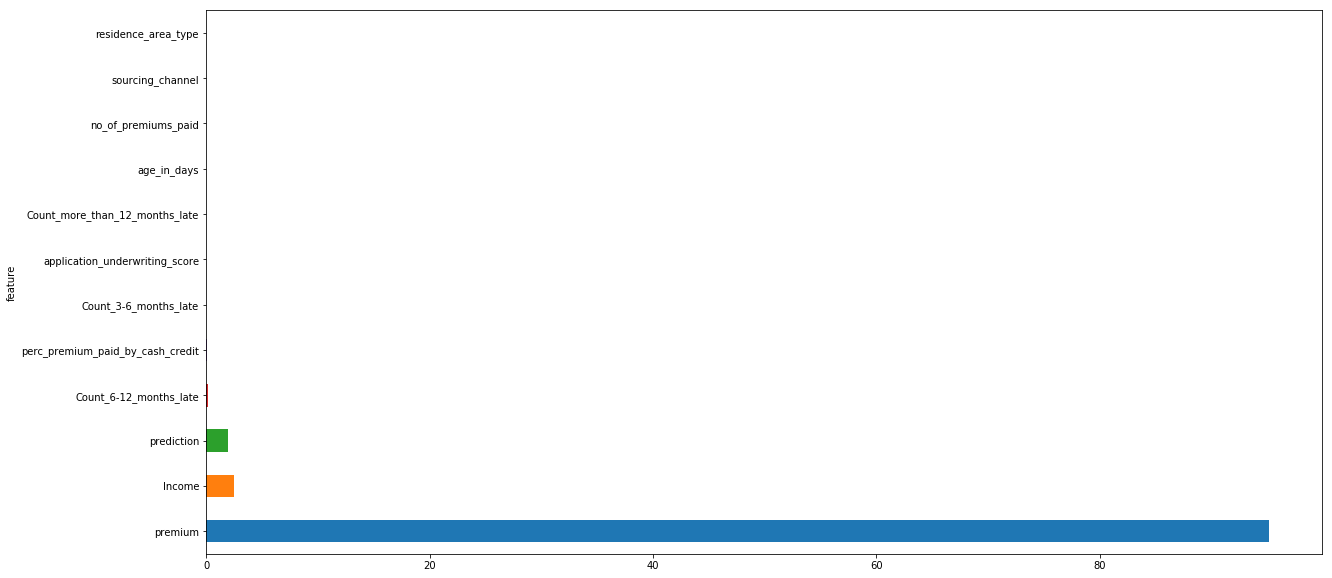

In [15]:
# Print Feature Importance
feature_importance = feature_importance.groupby("feature")["gain"].mean().reset_index().sort_values('gain', ascending=False).reset_index(drop=True)
plt.figure()
feature_importance[['feature','gain']].head(60).plot(kind='barh', x='feature', y='gain', legend=False, figsize=(20, 10));


In [16]:
submission = submission[["id"]].merge(test_id[["id","renewal","incentives"]], how = "left", on = "id")
submission = submission[["id", "renewal", "incentives"]]
submission.loc[submission.incentives < 0,"incentives"] = 0
submission.to_csv("csv/eda6.csv", index=False)

In [17]:
submission

,id,renewal,incentives
0,649,0.928576,175.250404
1,81136,0.680014,400.694243
2,70762,0.152133,199.040092
3,53935,0.498767,210.600689
4,15476,0.369223,295.507412
5,64797,0.739373,401.500611
6,67412,0.080078,83.546187
7,44241,0.074544,83.080428
8,5069,0.956481,475.405678
9,16615,0.896780,642.383552
